In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_combined'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
import h5py

def load_decoding_data(animals, session, notebook, cellreg=False):
#     patterns = dict(zip(animals, [ut.load_variable('patterns_evs', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
#                                     for ani in animals]))
#     labels = dict(zip(animals, [ut.load_variable('labels', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
#                                         for ani in animals]))
    
    patterns = ut.load_all_animals_vars('patterns_evs', animals, session, notebook,)
    labels = ut.load_all_animals_vars('labels', animals, session, notebook)
    if cellreg:
        cellregs = {}
        for ani in animals:
            try:
                cellregs[ani] = load_cellreg(ani)
            except IOError:
                raise Exception("Cannot find cellreg data for %s."%ani)
        for k, v in patterns.items():
            patterns[k] = patterns[k][:, cellregs[k][session]]
    else:
        cellregs = None

    return patterns, labels


def do_decoding_combined_within(animals, session, notebook, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
    
    patterns, labels = load_decoding_data(animals, session, notebook, cellreg)
    
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

def do_test_across(patterns_train, labels_train, patterns_test, labels_test, **args):
    x, y, _, _ = combine_train_test_patterns(patterns_train, labels_train, train_test_split=1, **args)
    xT, yT, _, _ = combine_train_test_patterns(patterns_test, labels_test, train_test_split=1, **args)
    decoder.fit(x, t)
    return decoder.score(xT, yT)

def plot_scores_compare2(score1, score2, colors=['b', 'r',], labels=True, chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 2))
    values = [score1*100, score2*100]
    pt.plot_bars(values, ax=ax, colors=colors, stderr=True)
    if chance is not None:
        ax.hlines(chance, -0.5, 2-0.5, linestyles='dashed')

    ax.set_xticks(range(2))
    ax.set_xticklabels(['pre', 'post'], rotation=30)
    
    ax.set_ylim(0,100)

    if labels:
        ax.set_ylabel('Decoding Performance (%)')
    pvs = []
    pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]

    # if savefig:
    # fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
    # np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')
    
    return ax

def plot_scores_vs_ncells(ncells, scores, labels=True, dot_color=(1, 0.7, 0.7), color='r', chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 1))
    ax.plot(ncells, scores*100, 'o', ms=2, mew=0, color=dot_color, zorder=0)
    ax.errorbar(ncells[::5], scores.reshape(-1, 5).mean(1)*100,
                np.std(scores.reshape(-1, 5), 1)*100,
                color=color)
    ax.set_ylim(0, 100)
    
    if labels:
        ax.set_xlabel("No. of Cells")
        ax.set_ylabel("Performance")

    if chance is not None:
        xmin, xmax, _, _  = ax.axis()
        ax.hlines(chance, xmin, xmax, linestyles='dashed', lw=0.5, color='k')

    # if savefig:
    # fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
    # np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')
    return ax

def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict
#try:
#    filepath = '../data/cellreg_preVSpost.mat'
#    arrays = {}
#    f = h5py.File(filepath)
#    cellreg_map = np.array(f['cell_registered_struct']['cell_to_index_map'])-1
#    keep = np.prod(cellreg_map, 0)>0
#    cellregs_preVSpost = dict(zip(['pre_post', 'post_pre'], cellreg_map.T[keep].T.astype(int)))
#except:
#    print 'not there'


In [6]:
import glob
animals = [ani[3:] for ani in glob.glob("../*")
           if
           ani != '../img' and
           ani != '../notebooks' and
          ani != '../general notebooks']
print animals

['90', '90_475', '91', '93_500', '93_580', '93_720', '93_810', 'c10m6', 'c10m6_587', 'c10m8', 'c3f3', 'c3m1', 'c3m1_725', 'c3m2', 'c3m2_645', 'dhpc35', 'dhpc35_254', 'dhpc36', 'dhpc36_290', 'dhpcg20', 'dhpcg20_200']


In [11]:
#vhpc_animals = [ani for ani in animals if ani[0]!='d']
vhpc_pre_animals = 'c3m1', 'c3m2', 'c3f3','c10m8'
vhpc_post_animals = '90','90_475','91','93_500','93_580','93_720','93_810','c3m1', 'c3m2', 'c3f3', 'c10m8'
dhpc_animals = [ani for ani in animals if ani[0]=='d']
#print "VENTRAL:", vhpc_animals
print "VENTRAL:", vhpc_pre_animals
print "DORSAL:", dhpc_animals

VENTRAL: ('c3m1', 'c3m2', 'c3f3', 'c10m8')
DORSAL: ['dhpc35', 'dhpc35_254', 'dhpc36', 'dhpc36_290', 'dhpcg20', 'dhpcg20_200']


In [12]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')
    
cv = LeaveOneOut()

In [13]:
scores_vhpc_post, ncells, scores_vhpc_post_ncells = do_decoding_combined_within(vhpc_post_animals, 'post', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5))
scores_vhpc_pre, ncells, scores_vhpc_pre_ncells = do_decoding_combined_within(vhpc_pre_animals, 'pre', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5))

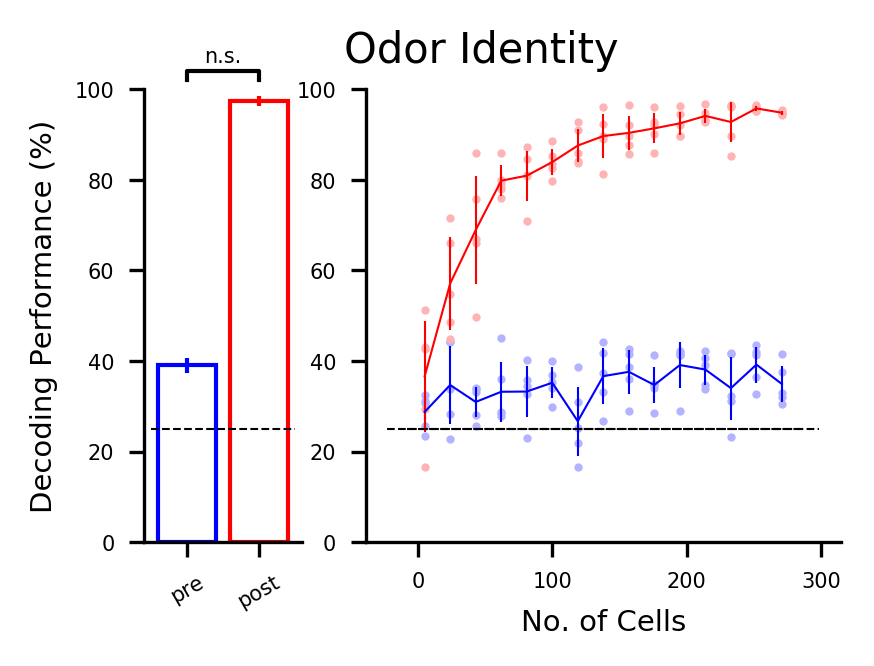

In [14]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_vhpc_pre, scores_vhpc_post, chance=25, ax=axs[0])

plot_scores_vs_ncells(ncells, scores_vhpc_pre_ncells, dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(ncells, scores_vhpc_post_ncells, ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity", fontsize=10)

## CS+/CS-

In [15]:
relabel = {1:0, 2:0, 3:1, 4:1}

In [16]:
scores_cspm_vhpc_post, ncells, scores_cspm_vhpc_post_ncells = do_decoding_combined_within(vhpc_post_animals, 'post', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), relabel=relabel)
scores_cspm_vhpc_pre, ncells, scores_cspm_vhpc_pre_ncells = do_decoding_combined_within(vhpc_pre_animals, 'pre', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), relabel=relabel)

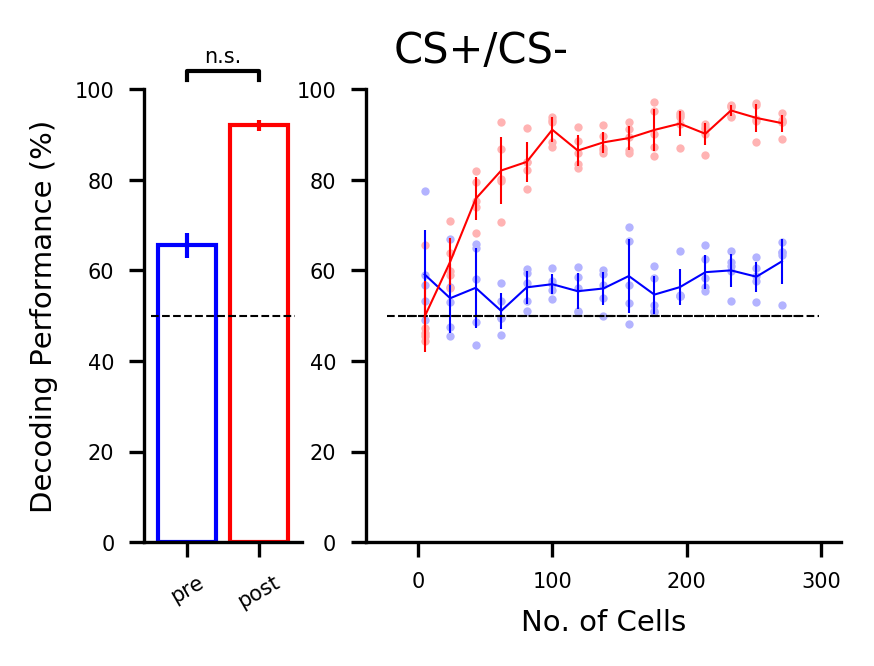

In [20]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_cspm_vhpc_pre, scores_cspm_vhpc_post, chance=50, ax=axs[0])

plot_scores_vs_ncells(ncells, scores_cspm_vhpc_pre_ncells, dot_color=(0.7, 0.7, 1), color='b', chance=50, ax=axs[1], labels=False)
plot_scores_vs_ncells(ncells, scores_cspm_vhpc_post_ncells, ax=axs[1], chance=50, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+/CS-", fontsize=10)

# Cellreg

In [21]:
cellreged_animals =  'c3m1', 'c3m2', 'c3f3', 'c10m6',

In [22]:
scores_vhpc_post_cr, ncells, scores_vhpc_post_ncells_cr = do_decoding_combined_within(cellreged_animals, 'post', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), cellreg=True)
scores_vhpc_pre_cr, ncells, scores_vhpc_pre_ncells_cr = do_decoding_combined_within(cellreged_animals, 'pre', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), cellreg=True)

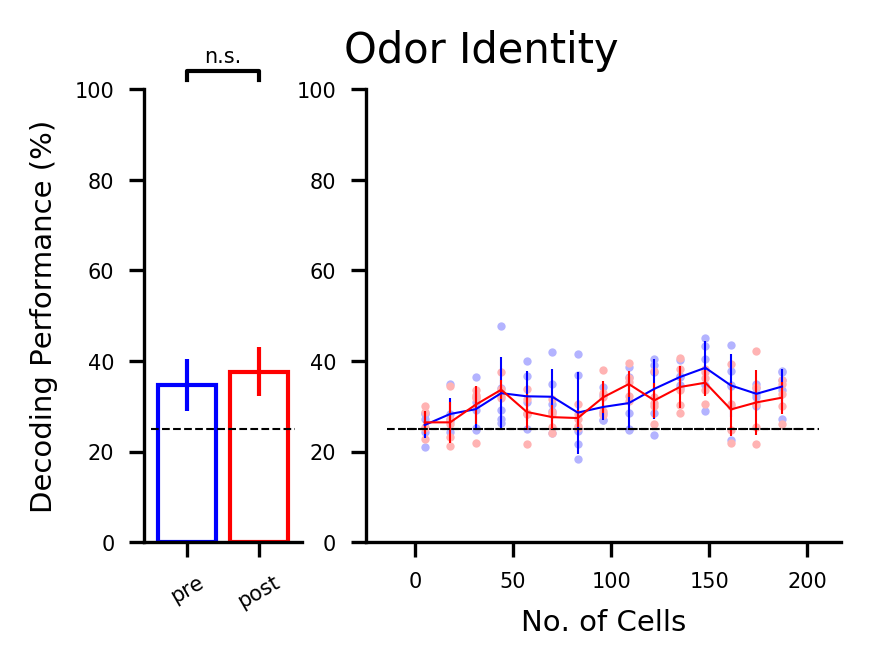

In [23]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_vhpc_pre_cr, scores_vhpc_post_cr, chance=25, ax=axs[0])

plot_scores_vs_ncells(ncells, scores_vhpc_pre_ncells_cr, dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(ncells, scores_vhpc_post_ncells_cr, ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity", fontsize=10)

In [25]:
scores_cspm_vhpc_post_cr, ncells, scores_cspm_vhpc_post_ncells_cr = do_decoding_combined_within(cellreged_animals, 'post', 'decoding_four_odors',
                                                                 n_loops=5, classes=range(1, 5), relabel=relabel, cellreg=True)
scores_cspm_vhpc_pre_cr, ncells, scores_cspm_vhpc_pre_ncells_cr = do_decoding_combined_within(cellreged_animals, 'pre', 'decoding_four_odors',
                                                                 n_loops=5, classes=range(1, 5), relabel=relabel, cellreg=True)

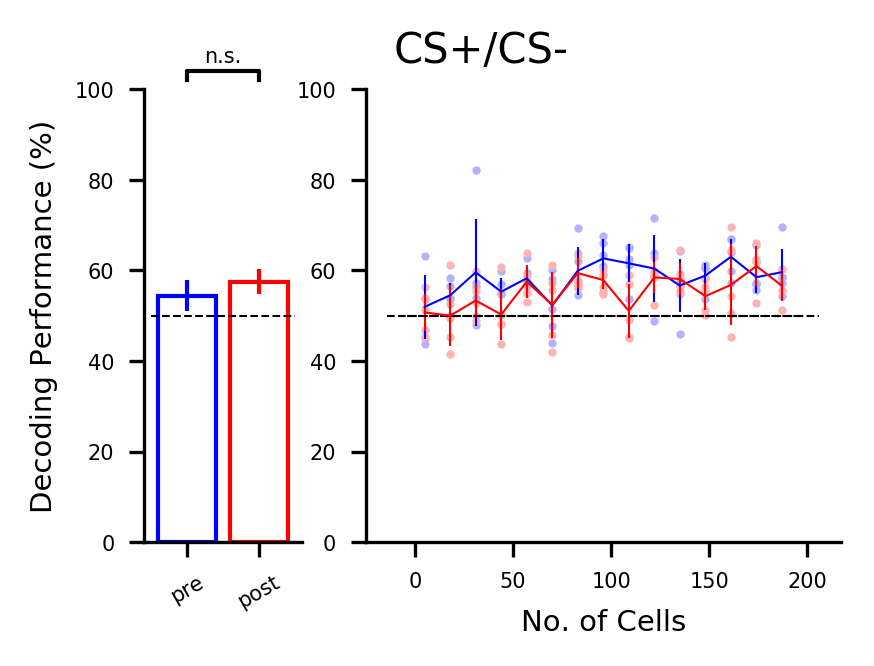

In [26]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_cspm_vhpc_pre_cr, scores_cspm_vhpc_post_cr, chance=50, ax=axs[0])

plot_scores_vs_ncells(ncells, scores_cspm_vhpc_pre_ncells_cr, dot_color=(0.7, 0.7, 1), color='b', chance=50, ax=axs[1], labels=False)
plot_scores_vs_ncells(ncells, scores_cspm_vhpc_post_ncells_cr, ax=axs[1], chance=50, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+/CS-", fontsize=10)

# Valence

In [48]:
patterns, labels = load_decoding_data(vhpc_post_animals, 'post', 'decoding_four_odors')
relabel_train = {1:0, 2:-1, 3:1, 4:-1}
relabel_test = {1:-1, 2:0, 3:-1, 4:1}
x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5),
                                           relabel=relabel_train, relabel_test=relabel_test)
decoder.fit(x, y)
decoder.score(xT, yT)

0.40999999999999998

In [35]:
animals = vhpc_post_animals

def do_decoding(animals, session, notebook):

    patterns, labels = load_decoding_data(animals, session, notebook)

    def do_it(n_cells=None):
        scores = []
        
        relabel_train = {1:0, 2:-1, 3:1, 4:-1}
        relabel_test = {1:-1, 2:0, 3:-1, 4:1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:0, 2:-1, 3:-1, 4:1}
        relabel_test = {1:-1, 2:0, 3:1, 4:-1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:-1, 2:0, 3:1, 4:-1}
        relabel_test = {1:0, 2:-1, 3:-1, 4:1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:-1, 2:0, 3:-1, 4:1}
        relabel_test = {1:0, 2:-1, 3:1, 4:-1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        return scores

    n_loops = 15
    scores = np.r_[[do_it(n_cells=None) for i in range(n_loops)]].flatten()

    n_steps = 5
    total_n = np.sum([patterns[ani].shape[1] for ani in animals])
    ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)

    scores_ncells = np.r_[[np.mean(do_it(n_cells=n)) for n in ncells]]
    
    return scores, ncells, scores_ncells

scores_vhpc_pre_valence, ncells, scores_vhpc_pre_ncells_valence = do_decoding(vhpc_pre_animals, 'pre', 'decoding_four_odors')
scores_vhpc_post_valence, ncells, scores_vhpc_post_ncells_valence = do_decoding(vhpc_pre_animals, 'post', 'decoding_four_odors')

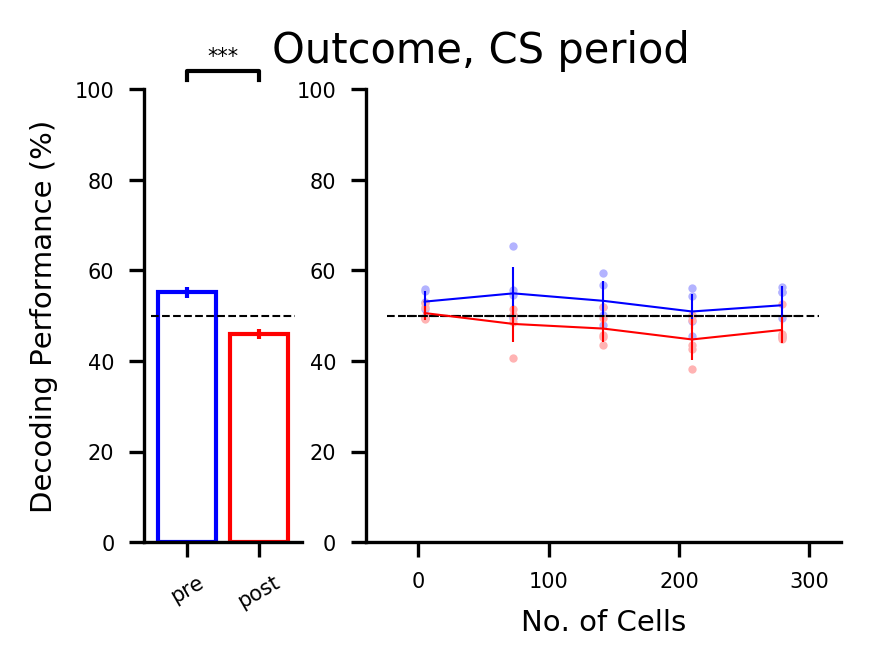

In [36]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(scores_vhpc_pre_valence, scores_vhpc_post_valence, chance=50, ax=axs[0])

plot_scores_vs_ncells(ncells, scores_vhpc_pre_ncells_valence, dot_color=(0.7, 0.7, 1), color='b', chance=50, ax=axs[1], labels=False)
plot_scores_vs_ncells(ncells, scores_vhpc_post_ncells_valence, ax=axs[1], chance=50, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Outcome, CS period", fontsize=10)
fig.savefig('../img/%s_outcome.jpg'%NOTEBOOK_NAME)